In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)

#seaborn Gr-Bk-Rd palette
pal = sns.diverging_palette(127.7, 12.2, l=53.4, n=255, center="dark")

pd.set_option('display.max_columns', 500)

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test #logrank test를 적용함. multivariate_logrank_test, pairwise_logrank_test, survival_difference_at_fixed_point_in_time_test 이용 가능
import matplotlib.pyplot as plt
kmf = KaplanMeierFitter()

from scipy import stats

---
## TARGET-ALL 전처리

In [2]:
#data input
table = pd.read_csv("./all_phase2_target_2018_pub_(pediatric)/all_phase2_target_2018_pub_clinical_data.csv")
rna = pd.read_csv("./all_phase2_target_2018_pub_(pediatric)/data_expression_median.txt", sep = '\t', header = None).T

rna.columns = rna.iloc[0,:]
rna = rna[2:]

table = pd.merge(table, rna, left_on = 'Sample ID', right_on = 'Hugo_Symbol')

table.to_csv('./target.csv')

C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249

In [3]:
table.head()

,Study ID,Patient ID,Sample ID,Diagnosis Age,Diagnosis Age (days),Alternative Therapy Given,Other Alternative Therapy Given,Analysis Cohort,BCR ABL1 Status,Bone Marrow Blasts Day 15,Bone Marrow Blasts Day 29,Bone Marrow Blasts Day 43,Bone Marrow Blasts Day 8,Bone Marrow Site of Relapse,Cancer Type,Cancer Type Detailed,Cell of tumor origin,CNS Site of Relapse,CNS Status,Congenital Abnormality,Death from Initial Pathologic Diagnosis Date,Time To Event (days),DNA Index,Ethnicity Category,ETV6-RUNX1 Fusion Status,First Event,Fraction Genome Altered,Karyotype,MLL Status,Molecular Subtype,MRD Percentage at end of Consolidation,MRD Percentage at end of Consolidation Sensitivity,MRD Percentage Day 29,MRD Percentage Day 29 Sensitivity,MRD Percentage Day 43,MRD Percentage Day 43 Sensitivity,MRD Percentage Day 8,MRD Percentage Day 8 Sensitivity,Mutation Count,Oncotree Code,Overall Survival Days,Overall Survival (Months),Overall Survival Status,Other Site of Relapse,Protocol,Race Category,Number of Samples Per Patient,Sex,TCF3-PBX1 Status,Testes Site of Relapse,Testicular Involvement,Trisomy 4_10,WBC,Hugo_Symbol,DDR1,RFC2,LOC652878,PAX8,GUCA1A,UBE1L,THRA,PTPN21,CCL5,CYP2E1,EPHB3,ESRRA,CYP2A6,SCARB1,TTLL12,MGC4677,WFDC2,MAPK1,ADAM32,SPATA17,MGC24975,PXK,VPS18,C9ORF30,HCP1,TIMD4,SLC39A5,ZDHHC11,ATP6V1E2,AFG3L1,PIGX,MGC42090,SLC39A13,VMD2L2,C6ORF199,CORO6,LOC653374,ALG10,C18ORF17,NEXN,C15ORF40,RAXL1,MFAP3,EYA3,GIMAP1,KLK8,CCDC65,FAM122C,CCDC11,ARMCX4,RBBP6,MGC16385,TRIOBP,CATSPER1,HOXD4,GSC,SP7,PDE7A,CNOT7,CRYZL1,PRSS33,C19ORF26,C8ORF45,TIRAP,LEAP2,MSI2,SCIN,CTCFL,LOC132321,FAM18B2,RDH10,SRRP35,FAM71A,C5ORF29,FLJ30901,C8ORF47,C1ORF65,RP1-172B20.3,TSSK3,WFDC6,CLEC12A,BRF1,C15ORF27,CALML6,NALP5,ODF4,CLEC4F,DEFB106A,WFDC9,NEDD1,TTLL10,CALR3,C10ORF25,ETV3,KLHL10,TM2D3,ZNF485,WDR17,FLJ35773,CDH23,ANKAR,MEGF11,ADMR,ESX1,C8ORF12,SCGB1C1,DNAJC5G,LOC126248,C9ORF65,MBD3L2,ADAMTSL1,MBD3L1,FAM46D,SERPINB11,C21ORF100,DSCR10,ABHD11,CENTB2,GAMT,PLCD3,IRF6,PTPRC,MAN1A2,RAPH1,SMCR8,LACTB,BNC1,MPP4,LACE1,IDI2,CYP11B1,TBN,COBL,SLAMF6,ZNF31,GPBAR1,RHBDL2,FRAS1,BRSK1,CRB2,KCNE4,CD300LG,SLC34A3,CPA6,CTA-250D10.11,HIPK1,MTBP,ACVR1C,TMEM74,TIGD4,ART5,FAM71C,C21ORF69,NALP11,ATP6V1C2,CLDN19,VTI1A,KIF6,IQCD,TAGAP,STON2,SERPINA12,LETM2,BSND,CLEC4C,CARD12,PRSS36,ZDHHC15,RAI1,ALS2CR7,ZNF570,C8ORF6,NUDT9P1,BTBD16,RTP3,C21ORF29,MIPOL1,C6ORF141,LOC200420,MYO3B,ADAM21,FLJ25801,ABCC13,IL12RB1,ALF,TRPV3,CNBD1,ABCC12,MMP21,MDAC1,GAS2L2,KCNG4,PXT1,CACNG5,C21ORF74,CXORF52,...,SPATA5,DPPA5,C16ORF65,LOC643449,NUDT10,LSM11,ZNF582,LOC389834,LOC653071,LOC401056,BOLA2,LOC641748,LOC643542,LOC400120,ACPT,LOC285281,SRFBP1,PRAM1,LOC347273,ZNF615,LOC339240,LOC644112,C19ORF45,SNORA28,OR2W3,LOC440905,LOC553103,LOC647786,TMEM16G,PXDNL,ACOT6,LOC647262,SRD5A2L2,LOC401588,RAB3C,MGC39715,RHOV,LOC389073,RP11-308D16.4,LOC339316,PAQR7,LOC647510,LOC652837,LOC113386,WDR69,LIPI,LOC401356,ADAMTSL5,WFDC5,ANKRD33,LOC388720,LOC440894,TMEM162,SLC26A9,ZFPM1,LOC199899,CXORF50,CBLN2,LOC645620,CCBE1,LOC401317,LOC283904,NALP4,FAM19A4,ST8SIA6,LOC646968,LOC255275,LOC650195,LOC283278,LOC647974,NRG4,C1ORF141,ZNF600,LOC120376,EID-3,LOC647135,GSTA2,MGC27016,KISS1R,LOC284948,LOC642398,GPR137C,TSSK4,LOC253012,NBPF9,CCDC37,GCRG224,C15ORF21,LOC650269,FLJ38028,LOC653086,ARL5B,LOC391269,LOC650874,PGLYRP2,RNF207,OTOS,LOC652905,RNF148,VWCE,LOC400796,DCST2,LOC644829,RDH12,RP11-38L15.1,LOC441242,LOC150084,C2ORF38,LOC643831,FLJ34515,LOC387978,FLJ16734,WDR63,NPW,FLJ16423,FAM24A,UTS2D,ZNF283,MGC33407,FLJ39822,C17ORF55,C11ORF38,LOC283335,C1QDC2,LOC220729,LOC286109,FLJ27352,RP5-1103G7.6,FREM3,LOC648832,FAM7A1,LOC641518,CERKL,LOC642237,PRH2,LOC643406,LOC440268,KCNQ1OT1,LOC642891,ZNF418,LOC643675,LOC349136,C10ORF130,KIAA1841,ADH1C,FLJ39639,LOC646470,LOC158230,LOC285957,SPACA3,LOC145694,LOC642333,PRAP1,LOC285431,FAM47A,TMEM132E,PYDC1,LOC388481,LOC389070,C21ORF70,LOC650794,DNHD2,LOC643037,PGBD4,LOC642981,ZCWPW2,LOC644241,C13ORF26,LOC646865,LOC644529,LOC647263,LOC653527,LOC645106,LOC285286,LOC645032,LOC541472,C20ORF175,LOC144766,KRT222P,A

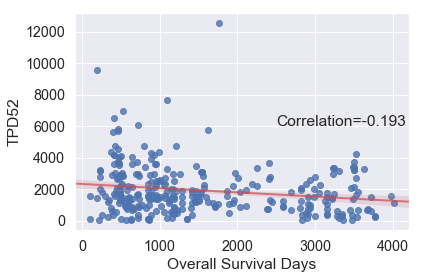

In [130]:
#TPD52-survival days correlation 확인
ax = sns.regplot(x=df["Overall Survival Days"], y=df["TPD52"], line_kws={"color":"r","alpha":0.7,"lw":2})
ax.text(2500,6000,'Correlation=%.3f'% scipy.stats.spearmanr(df)[0])
plt.savefig('./reg.png', dpi=300, bbox_inches='tight')

In [27]:
#converting data: vital_status >>> bool, days_to_birth >>> abs(int)
table['First Event'] = (table['First Event'] == 'Death')
table['Overall Survival Days'] = abs(table['Overall Survival Days'].astype(int))

In [82]:
table = table.sort_values(["TPD52"], ascending=[False])
table = table.reset_index(drop=True)

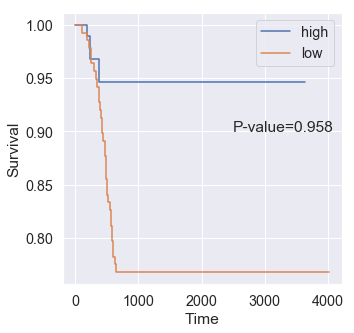

In [125]:
fig, ax = plt.subplots(figsize=(5,5))

#TPD52가 평균 초과/미만인 그룹을 나누어 생존분석 수행

mask = table['TPD52'] > table['TPD52'].mean()
time, survival_prob = kaplan_meier_estimator(table['First Event'][mask], table['Overall Survival Days'][mask])
kmf.fit(time, survival_prob, label='high')
kmf.plot(ax=ax, ci_show=False)

mask2 = table['TPD52'] < table['TPD52'].mean()
time, survival_prob = kaplan_meier_estimator(table['First Event'][mask2], table['Overall Survival Days'][mask2])
kmf.fit(time, survival_prob, label='low')
kmf.plot(ax=ax, ci_show=False)

#logrank test. https://lifelines.readthedocs.io/en/latest/lifelines.statistics.html 참고
result = logrank_test(table['First Event'][mask], table['First Event'][mask2], table['Overall Survival Days'][mask], table['Overall Survival Days'][mask2], alpha=.99)
pvalue = result.p_value
ax.text(2500,0.9,'P-value=%.3f'% pvalue)

ax.set_xlabel('Time')
ax.set_ylabel('Survival')

plt.savefig('./survival.png', dpi=300, bbox_inches='tight')